In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime

In [2]:
def parser(x):
    return datetime.strptime(x,'%Y-%m-%d')

In [3]:
df=pd.read_csv('prepared_individual_data/Indigestion.csv',index_col=0,parse_dates=[0],date_parser=parser)

/home/manjit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [4]:
df.head()

,Indigestion
Date,
2018-06-01,0
2018-06-02,0
2018-06-03,0
2018-06-04,0
2018-06-05,0


In [5]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

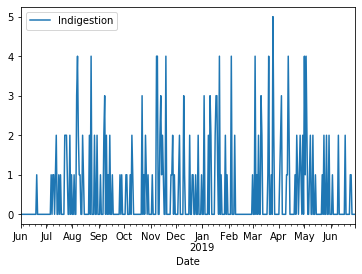

In [6]:
df.plot()

In [7]:
df_urti_weeklyS = df.resample('W').sum()
df_urti_weeklyM = df.resample('W').mean()

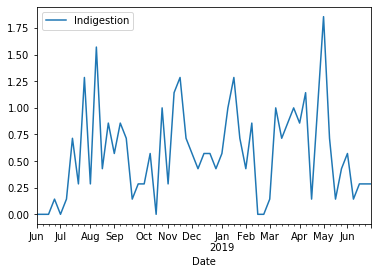

In [8]:
df_urti_weeklyM.plot()

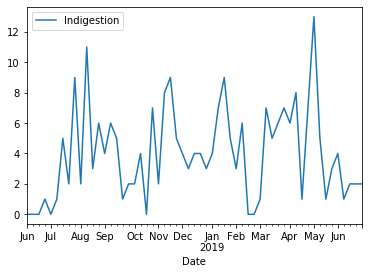

In [9]:
df_urti_weeklyS.plot()

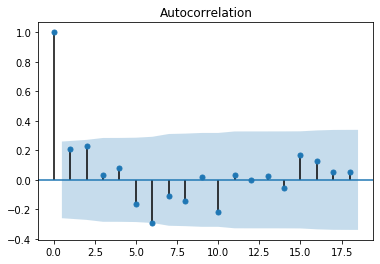

In [10]:
plot_acf(df_urti_weeklyM);

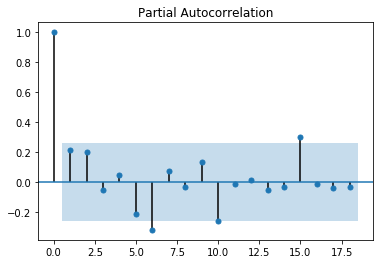

In [11]:
plot_pacf(df_urti_weeklyM);

# ARMA on weekly data

In [12]:
df_weekly=df_urti_weeklyM.diff(2)[2:]

In [13]:
df_weekly.head()

,Indigestion
Date,
2018-06-17,0.000000
2018-06-24,0.142857
2018-07-01,0.000000
2018-07-08,0.000000
2018-07-15,0.714286


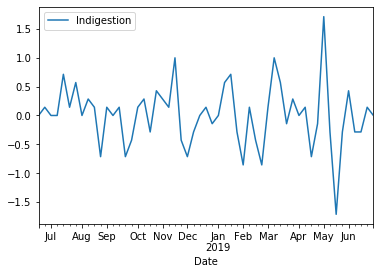

In [14]:
df_weekly.plot()

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
X=df_weekly[df_weekly.columns[0]].values
result=adfuller(X)
print("ADF Statistic: %f" % result[0])
print("p-value:  %f" % result[1])
print('Critical values: ')
for key,value in result[4].items():
    print("\t%s: %.3f" % (key,value))
if result[0] < result[4]["5%"]:
    print("Reject Ho - Time Series is stationary")
else:
    print("Failed to reject Ho - Time Series is not stationary")

ADF Statistic: -7.578492
p-value:  0.000000
Critical values: 
	1%: -3.560
	5%: -2.918
	10%: -2.597
Reject Ho - Time Series is stationary


In [17]:
df_weekly.size

55

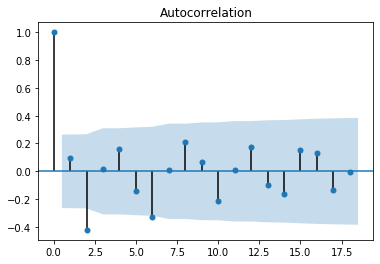

In [18]:
plot_acf(df_weekly);

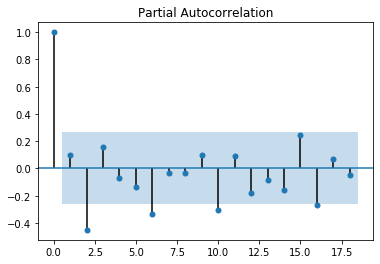

In [19]:
plot_pacf(df_weekly);

In [20]:
total=df_weekly
test_size=int(0.20*total.size)
train_size=total.size-test_size

In [21]:
test_size

11

In [22]:
train_size

44

In [23]:
total.size

55

In [24]:
train=total[:train_size]

In [25]:
test=total[train_size:]

In [26]:
train.size+test.size

55

In [27]:
from statsmodels.tsa.stattools import acf,pacf

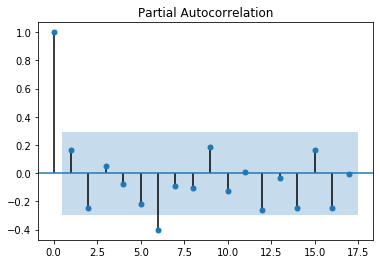

In [28]:
plot_pacf(train,alpha=0.05);

In [29]:
pacf_res=pacf(train,alpha=0.5)
print(pacf_res[0][3], " -- ",pacf_res[1][3])

0.05072444671816691  --  [-0.05095871  0.1524076 ]


/home/manjit/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


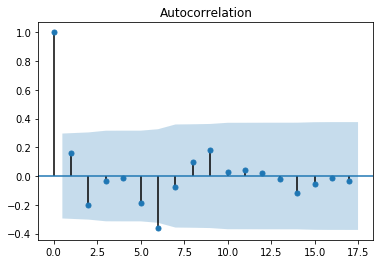

In [30]:
plot_acf(train);

In [31]:
acf_res=acf(train,alpha=0.5)
print(acf_res[0][1], " -- ",acf_res[1][1])

0.1630685547224598  --  [0.0613854  0.26475171]


/home/manjit/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


In [32]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
arma_model=ARMA(train,order=(10,10))
arma_model_fit=arma_model.fit()

In [112]:
arma_preds=arma_model_fit.predict(start=(train_size),end=(total.size-1))

In [113]:
arma_preds.size

11

In [114]:
arma_preds

2019-04-21   -0.635285
2019-04-28   -0.496560
2019-05-05    0.443461
2019-05-12    0.263923
2019-05-19   -0.019884
2019-05-26   -0.208409
2019-06-02    0.230347
2019-06-09   -0.350489
2019-06-16    0.132756
2019-06-23    0.083363
2019-06-30    0.090043
Freq: W-SUN, dtype: float64

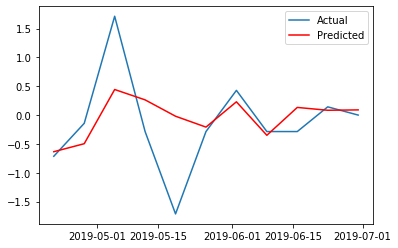

In [115]:
plt.plot(test,label='Actual')
plt.plot(arma_preds,color='red',label='Predicted')
plt.legend()

In [116]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acs

In [117]:
mse(y_true=test,y_pred=arma_preds)

0.4686973628115744

In [282]:
pred_values=arma_preds.values
test_values=test.values

In [ ]:
import pickle
from pickle_class_info import SerializableData
obj=SerializableData(train,arma_model_fit,'acidity')

In [ ]:
f=open('model_'+obj.label,'wb')
pickle.dump(obj,f)
f.close()